# Проект: классификация открытия депозита

In [316]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder, MinMaxScaler
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [317]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [318]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
print('Пропущенные значения по всем признакам:')
df.isnull().sum()

Пропущенные значения по всем признакам:


age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [319]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
print('Количество значений в признаке job:')
df.job.value_counts()

Количество значений в признаке job:


management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [320]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
print('Количество значений в признаке balance:')
df.balance.value_counts()

Количество значений в признаке balance:


0  $            774
 1,00 $          39
 3,00 $          34
 2,00 $          34
 4,00 $          29
               ... 
 1 641,00 $       1
 5 517,00 $       1
 8 332,00 $       1
 4 859,00 $       1
-134,00 $         1
Name: balance, Length: 3802, dtype: int64

In [321]:
df['balance'] = df['balance'].apply(lambda x: 
                                    str(x).replace(' ', '').replace('$', '').replace(',', '.')).astype('float')
print('Среднее значение в признаке balance после перевода в вещественные числа:')
df['balance'].mean()

Среднее значение в признаке balance после перевода в вещественные числа:


1529.1290293615875

### Задание 4

In [322]:
# обработайте пропуски в признаки balance, заменив их на медианные значения по данному признаку
# ваш код

df.loc[(df['balance'].isnull()==True),'balance']=df['balance'].median() # ваш код здесь 
print('Среднее значение в признаке balance после замены пропусков на медиану:')
df['balance'].mean() 

Среднее значение в признаке balance после замены пропусков на медиану:


1526.9360329690019

### Задание 5

In [323]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
print('Количество значений в признаке education:')
df['education'].value_counts()

Количество значений в признаке education:


secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

In [324]:
df.loc[(df['job']=='unknown'),'job']=df['job'].mode()[0]
df.loc[(df['education']=='unknown'),'education']=df['education'].mode()[0]
# После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой и 
# самым популярным уровнем образования.
print('Среднее значение в признаке balance для популярных job и education:')
df[(df['job']==df['job'].mode()[0])&(df['education']==df['education'].mode()[0])]['balance'].mean()

Среднее значение в признаке balance для популярных job и education:


1598.8829787234042

### Задание 6

In [325]:
# удалите все выбросы для признака balance
# ваш код
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

Соотношение классов в целевом признаке deposit:
no     5424
yes    4681
Name: deposit, dtype: int64


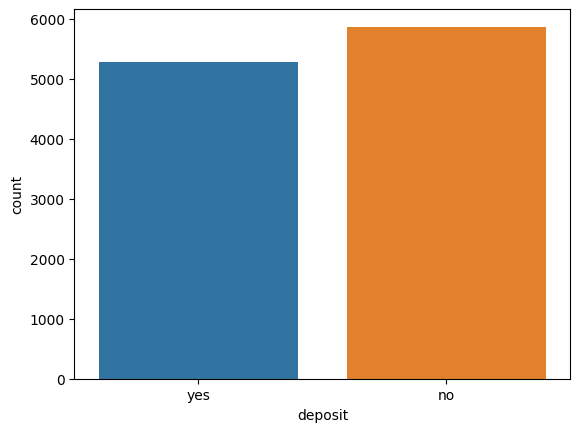

In [326]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
import seaborn as sns
print('Соотношение классов в целевом признаке deposit:')
print(cleaned['deposit'].value_counts())
sns.countplot(data=df, x='deposit');

В распределении целевой переменной, есть небольшой дисбаланс (54\46). На случай влияния данного дисбаланса классов при разбиении выборки, будем использовать стратифицированный (stratified) тип разбиения.

### Задания 2 и 3

In [327]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
print('Описательные статистики для количественных признаков:')
cleaned.describe()

Описательные статистики для количественных признаков:


,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [328]:
cleaned.pdays.value_counts(normalize=True).head(5)

-1      0.748936
 92     0.008709
 182    0.007620
 181    0.007422
 91     0.007323
Name: pdays, dtype: float64

После очистки данных от пропусков и выбросов, наблюдаем соотвествующие описательные статистики, количество значений во всех признаках равны между собой, средние значения и медианы в каждом признаке различаются не значительно. Минимальные и максимальные значения в каждом признаке в допустимых рамках. Кроме признака pdays, который имеет 75% одинаковых значений: -1. Даже если этот признак имеет хоть какую то корреляцию с целевым, то это ложная корреляция, поэтому логично его удалить. 

In [329]:
cleaned = cleaned.drop(['pdays'], axis=1)

### Задания 4 и 5

In [330]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
cleaned.describe(include='object')
#постройте визуализации, иллюстрирующие результаты

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


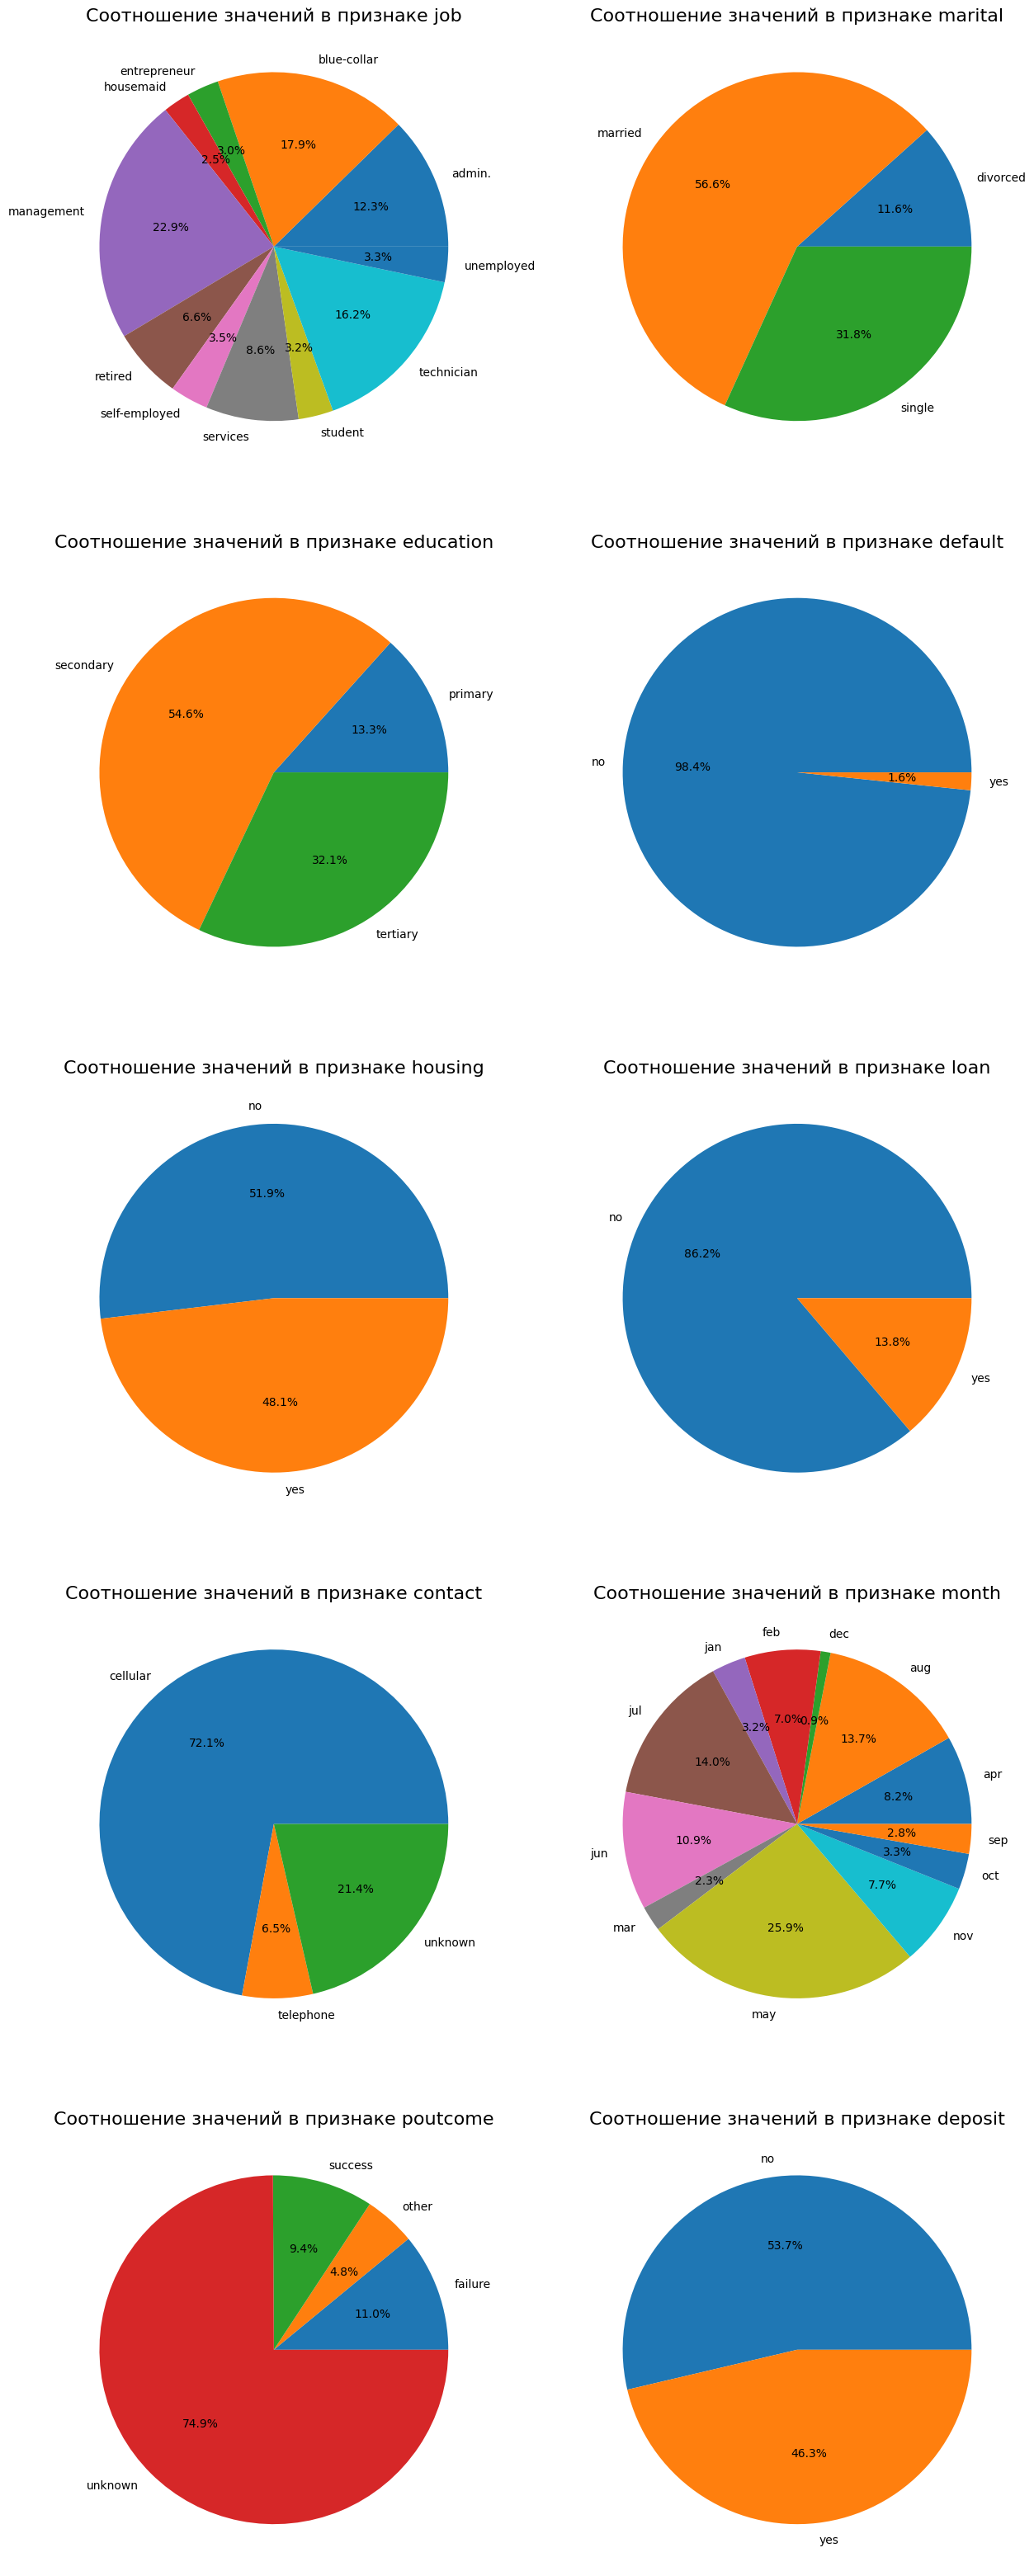

In [331]:
lst_features = [feature for feature in cleaned.columns if cleaned[feature].dtype=='O']
fig, axes = plt.subplots(int(len(lst_features)/2), 2,
        figsize=(15, len(lst_features)*4))
index_row = 0
for index_feature in range(0, len(lst_features), 2):
    for index_col in range(0, 2):
        feature = lst_features[index_feature+index_col]
        data_feature = cleaned[feature].value_counts().sort_index()
        axes[index_row][index_col].set_title('Соотношение значений в признаке ' + feature, fontsize=16)
        axes[index_row][index_col].pie(data_feature,
            labels=data_feature.index,
            autopct='%.1f%%') 
    index_row += 1


Фиксируем значительный дисбаланс в соотношении категорий в признаке default. Данный признак имеет 98% одинаковых значений. Логично его будет удалить.

In [332]:
cleaned = cleaned.drop(['default'], axis=1)

### Задание 6

In [333]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
df_group_by = cleaned.groupby(['poutcome', 'deposit'],as_index=False)['age'].count()
index = (df_group_by['age']-df_group_by['age'].shift(1)).loc[1::2].sort_values(ascending=False).index[0]
print('Cтатус предыдущей маркетинговой кампании, в которой успех в текущей превалирует над количеством неудач:')
df_group_by.iloc[[index-1, index]]

Cтатус предыдущей маркетинговой кампании, в которой успех в текущей превалирует над количеством неудач:


,poutcome,deposit,age
4,success,no,84
5,success,yes,861


### Задание 7

In [334]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
df_group_by = cleaned.groupby(['month', 'deposit'],as_index=False)['age'].count()
print('Месяце, в котором чаще всего отказывались от предложения открыть депозит:')
df_group_by[df_group_by['deposit']=='no'].sort_values('age', ascending=False).iloc[0]

Месяце, в котором чаще всего отказывались от предложения открыть депозит:


month       may
deposit      no
age        1776
Name: 16, dtype: object

### Задание 8

In [335]:
# создайте возрастные группы и определите, 
# в каких группах более склонны открывать депозит, чем отказываться от предложения
cleaned['age_cat'] = pd.cut(cleaned['age'], bins=[0, 29, 39, 49, 59, 100], 
                            labels=['<30', '30-40', '40-50', '50-60', '60+'])
df_group_by = cleaned.groupby(['age_cat', 'deposit'],as_index=False)['age'].count()
print('Количество значений в признаке age_cat в разрезе по целевому признаку deposit:')
df_group_by

Количество значений в признаке age_cat в разрезе по целевому признаку deposit:


,age_cat,deposit,age
0,<30,no,594
1,<30,yes,861
2,30-40,no,2245
3,30-40,yes,1716
4,40-50,no,1444
5,40-50,yes,938
6,50-60,no,984
7,50-60,yes,670
8,60+,no,157
9,60+,yes,496


In [336]:
serial = (df_group_by['age']-df_group_by['age'].shift(1)).loc[1::2].sort_values(ascending=False)
lst_index = serial[serial>0].index
print('Возврастные группы, которые более склонны открывать депозит, чем отказываться от предложения:')
for index in lst_index:
    print(df_group_by.iloc[[index-1, index]])

Возврастные группы, которые более склонны открывать депозит, чем отказываться от предложения:
  age_cat deposit  age
8     60+      no  157
9     60+     yes  496
  age_cat deposit  age
0     <30      no  594
1     <30     yes  861


### Задания 9 и 10

Соотношение значений категориальных признаков marital и education в разрезе целевого признака:


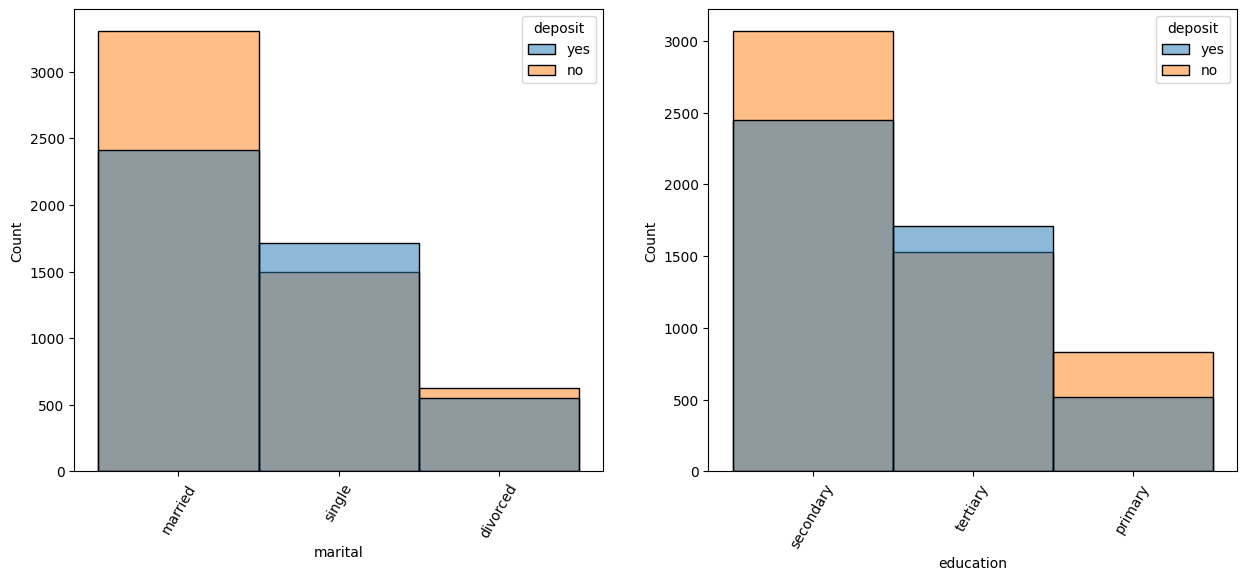

In [337]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса и образования
print('Соотношение значений категориальных признаков marital и education в разрезе целевого признака:')
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = sns.histplot(data=cleaned, x='marital', hue="deposit", ax=axes[0])
ax.xaxis.set_tick_params(rotation=60)
ax = sns.histplot(data=cleaned, x='education', hue="deposit", ax=axes[1])
ax.xaxis.set_tick_params(rotation=60)

Соотношение значений категориального признака job в разрезе целевого признака:


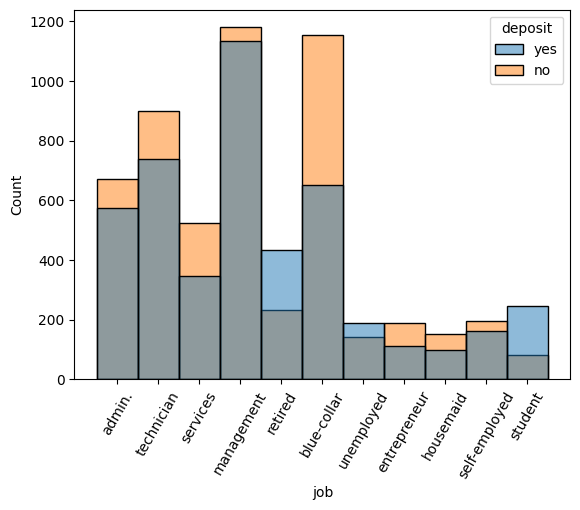

In [338]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
print('Соотношение значений категориального признака job в разрезе целевого признака:')
ax = sns.histplot(data=cleaned, x='job', hue="deposit")
ax.xaxis.set_tick_params(rotation=60)

### Задание 11

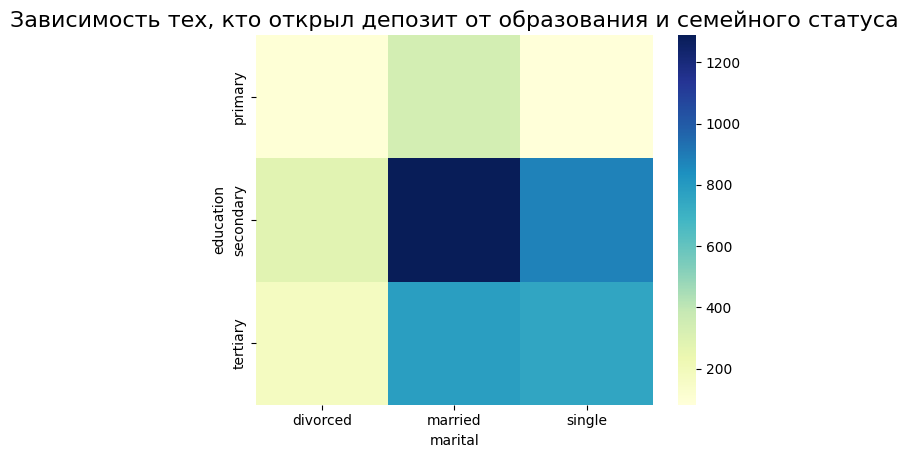

In [339]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
# (если рассматривать тех, кто открыл депозит)
cleaned['deposit'] = cleaned['deposit'].apply(lambda x: 0 if x == 'no' else 1).astype('bool')
df_pivot = cleaned.pivot_table(
    index='education',
    columns='marital',
    values='deposit',
    aggfunc='sum'
)
df_pivot.columns = df_pivot.columns.astype('string')
heatmap = sns.heatmap(data=df_pivot, cmap='YlGnBu')
heatmap.set_title('Зависимость тех, кто открыл депозит от образования и семейного статуса', fontsize=16);

## Часть 3: преобразование данных

### Задание 1

In [340]:
# преобразуйте уровни образования
le = LabelEncoder()
cleaned['education_coded'] = le.fit_transform(cleaned.education)
print('Сумма всех значений после кодирования признака education:')
cleaned['education_coded'].sum()

Сумма всех значений после кодирования признака education:


11995

In [341]:
# преобразуйте уровни возраста
le = LabelEncoder()
#le.fit(cleaned.age_cat)
le.classes_ = cleaned.age_cat.cat.categories
cleaned['age_cat_coded'] = le.transform(cleaned.age_cat)

### Задания 2 и 3

In [342]:
# Вычислите стандартное отклонение по преобразованной в корректный вид целевой переменной deposit
print('Стандартное отклонение признака deposit:')
cleaned['deposit'].std()

Стандартное отклонение признака deposit:


0.4986712532452124

In [343]:
# преобразуйте бинарные переменные в представление из нулей и единиц
#cleaned['default'] = cleaned['default'].apply(lambda x: 0 if x == 'no' else 1).astype('bool')
cleaned['housing'] = cleaned['housing'].apply(lambda x: 0 if x == 'no' else 1).astype('bool')
cleaned['loan'] = cleaned['loan'].apply(lambda x: 0 if x == 'no' else 1).astype('bool')

In [344]:
# Вычислите среднее арифметическое для каждой из получившихся переменных, 
# сложите три результата и в качестве ответа впишите итог
#cleaned['default'].mean() + cleaned['housing'].mean() + cleaned['loan'].mean()
cleaned['housing'].mean() + cleaned['loan'].mean()

0.6190004948045522

### Задание 4

In [345]:
# создайте дамми-переменные
cleaned_coded = pd.get_dummies(data=cleaned, columns=['job', 'marital',
                                                       'contact', 'month', 'poutcome'], dtype='bool')
cleaned_coded = cleaned_coded.drop(['age', 'age_cat', 'education'], axis=1)
print('Итоговый список признаков, после преобразования и кодирования признаков:')
cleaned_coded.columns

Итоговый список признаков, после преобразования и кодирования признаков:


Index(['balance', 'housing', 'loan', 'day', 'duration', 'campaign', 'previous',
       'deposit', 'education_coded', 'age_cat_coded', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

### Задания 5 и 6

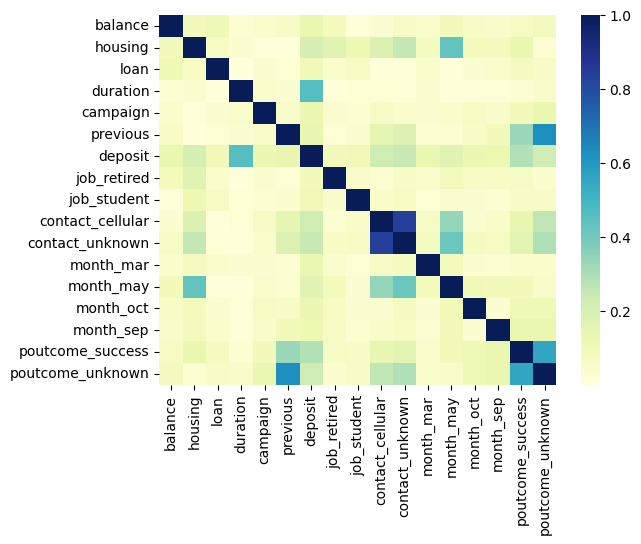

In [346]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corr = cleaned_coded.corr().abs()
corr = corr[corr['deposit']>0.1]
corr = corr.loc[:,corr.index]
sns.heatmap(data=corr, cmap='YlGnBu')
heatmap.set_title('Тепловая карта вакцинации', fontsize=16);

### Задания 7 и 8

In [347]:
X = cleaned_coded.drop(['deposit'], axis=1)
y = cleaned_coded['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [348]:
# рассчитайте необходимые показатели
print('Размер тестовой выборки: ', X_test.shape)
print('Среднее значение тестового целевого признака: ', y_test.mean())

Размер тестовой выборки:  (3335, 42)
Среднее значение тестового целевого признака:  0.46326836581709147


### Задание 9

In [349]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6770 entries, 7287 to 4966
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   balance            6770 non-null   float64
 1   housing            6770 non-null   bool   
 2   loan               6770 non-null   bool   
 3   day                6770 non-null   int64  
 4   duration           6770 non-null   int64  
 5   campaign           6770 non-null   int64  
 6   previous           6770 non-null   int64  
 7   education_coded    6770 non-null   int32  
 8   age_cat_coded      6770 non-null   int32  
 9   job_admin.         6770 non-null   bool   
 10  job_blue-collar    6770 non-null   bool   
 11  job_entrepreneur   6770 non-null   bool   
 12  job_housemaid      6770 non-null   bool   
 13  job_management     6770 non-null   bool   
 14  job_retired        6770 non-null   bool   
 15  job_self-employed  6770 non-null   bool   
 16  job_services       67

In [350]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
'''KBest = SelectKBest(f_classif, k=15)
KBest.fit(X_train, y_train)
array_train = KBest.transform(X_train)
array_test = KBest.transform(X_test)
X_train_anova = pd.DataFrame(array_train, columns=KBest.get_feature_names_out())
X_test_anova = pd.DataFrame(array_test, columns=KBest.get_feature_names_out())
print('Список признаков отобранных методом f_classif:')
print(X_train_anova.columns)'''

"KBest = SelectKBest(f_classif, k=15)\nKBest.fit(X_train, y_train)\narray_train = KBest.transform(X_train)\narray_test = KBest.transform(X_test)\nX_train_anova = pd.DataFrame(array_train, columns=KBest.get_feature_names_out())\nX_test_anova = pd.DataFrame(array_test, columns=KBest.get_feature_names_out())\nprint('Список признаков отобранных методом f_classif:')\nprint(X_train_anova.columns)"

In [351]:
FEATURES_COUNT = 10

In [352]:
imp_all = pd.Series(f_classif(X_train, y_train)[0], index = X_train.columns)
imp_anova = imp_all.sort_values(ascending=False).head(FEATURES_COUNT).index
X_train_anova = X_train[imp_anova]
X_test_anova = X_test[imp_anova]
print('Признаки оторанные тестом ANOVA:')
imp_anova

Признаки оторанные тестом ANOVA:


Index(['duration', 'poutcome_success', 'contact_unknown', 'poutcome_unknown',
       'contact_cellular', 'housing', 'month_may', 'previous', 'campaign',
       'month_sep'],
      dtype='object')

In [353]:
num_features = [feature for feature in X_train.columns if X_train[feature].dtype!='bool']
imp_num = pd.Series(f_classif(X_train[num_features], y_train)[0], index = num_features)

cat_features = [feature for feature in X_train.columns if X_train[feature].dtype=='bool']
imp_cat = pd.Series(chi2(X_train[cat_features], y_train)[0], index = cat_features)

imp_anova_chi2 = pd.concat([imp_num, imp_cat]).sort_values(ascending=False).head(FEATURES_COUNT).index
X_train_anova_chi2 = X_train[imp_anova_chi2]
X_test_anova_chi2 = X_test[imp_anova_chi2]
print('Признаки оторанные тестами ANOVA и Хи-квадрат:')
imp_anova_chi2

Признаки оторанные тестами ANOVA и Хи-квадрат:


Index(['duration', 'poutcome_success', 'contact_unknown', 'previous',
       'housing', 'campaign', 'month_may', 'month_sep', 'month_oct',
       'balance'],
      dtype='object')

### Задание 10

In [354]:
# нормализуйте данные X_train_anova с помощью minmaxsxaler
scaler = MinMaxScaler()
scaler.fit(X_train_anova)
X_train_anova_scaled = pd.DataFrame(scaler.transform(X_train_anova), columns=scaler.get_feature_names_out())
X_test_anova_scaled = pd.DataFrame(scaler.transform(X_test_anova), columns=scaler.get_feature_names_out())

In [355]:
# нормализуйте данные X_train_anova_chi2 с помощью minmaxsxaler
scaler = MinMaxScaler()
scaler.fit(X_train_anova_chi2)
X_train_anova_chi2_scaled = pd.DataFrame(scaler.transform(X_train_anova_chi2), columns=scaler.get_feature_names_out())
X_test_anova_chi2_scaled = pd.DataFrame(scaler.transform(X_test_anova_chi2), columns=scaler.get_feature_names_out())

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [356]:
# Объявим впомогательные функции
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj][0]

def split_str(string, step):
    for i in range(0, len(string), 120):
        string = string[0:i] + '\n' + string[i:]
    return string[:600]

def fit_predict(model, X_train, X_test, y_train, y_test):
    print('Имя модели: ', namestr(model, globals()))
    print('Класс модели: ', model.__class__)
    print('Гиперпараметры: ', split_str(str(model.get_params()), 120))
    print('Тренировочный набор: ' + namestr(X_train, globals())), 
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    print(metrics.classification_report(y_train, y_pred))
    print('Тестовый набор: ' + namestr(X_test, globals()))
    y_pred = model.predict(X_test)
    print(metrics.classification_report(y_test, y_pred))

In [357]:
# обучите логистическую регрессию и рассчитайте метрики качества
LogisticReg = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)
fit_predict(LogisticReg, X_train_anova_scaled, X_test_anova_scaled, y_train, y_test)

Имя модели:  LogisticReg
Класс модели:  <class 'sklearn.linear_model._logistic.LogisticRegression'>
Гиперпараметры:  
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_i
ter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'sag', 'tol': 0.0001,
 'verbose': 0, 'warm_start': False}
Тренировочный набор: X_train_anova_scaled
              precision    recall  f1-score   support

       False       0.78      0.87      0.82      3634
        True       0.82      0.72      0.77      3136

    accuracy                           0.80      6770
   macro avg       0.80      0.79      0.80      6770
weighted avg       0.80      0.80      0.80      6770

Тестовый набор: X_test_anova_scaled
              precision    recall  f1-score   support

       False       0.77      0.85      0.81      1790
        True       0.80      0.70      0.75      1545

    accuracy                         

In [358]:
fit_predict(LogisticReg, X_train_anova_chi2_scaled, X_test_anova_chi2_scaled, y_train, y_test)

Имя модели:  LogisticReg
Класс модели:  <class 'sklearn.linear_model._logistic.LogisticRegression'>
Гиперпараметры:  
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_i
ter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'sag', 'tol': 0.0001,
 'verbose': 0, 'warm_start': False}
Тренировочный набор: X_train_anova_chi2_scaled
              precision    recall  f1-score   support

       False       0.79      0.87      0.83      3634
        True       0.83      0.74      0.78      3136

    accuracy                           0.81      6770
   macro avg       0.81      0.80      0.81      6770
weighted avg       0.81      0.81      0.81      6770

Тестовый набор: X_test_anova_chi2_scaled
              precision    recall  f1-score   support

       False       0.78      0.86      0.82      1790
        True       0.82      0.71      0.76      1545

    accuracy               

### Задания 2,3,4

In [359]:
# обучите решающие деревья, настройте максимальную глубину

DecisionTree = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
fit_predict(DecisionTree, X_train_anova_scaled, X_test_anova_scaled, y_train, y_test)

Имя модели:  DecisionTree
Класс модели:  <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Гиперпараметры:  
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nod
es': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0
, 'random_state': 42, 'splitter': 'best'}
Тренировочный набор: X_train_anova_scaled
              precision    recall  f1-score   support

       False       0.95      0.99      0.97      3634
        True       0.99      0.94      0.96      3136

    accuracy                           0.97      6770
   macro avg       0.97      0.97      0.97      6770
weighted avg       0.97      0.97      0.97      6770

Тестовый набор: X_test_anova_scaled
              precision    recall  f1-score   support

       False       0.74      0.77      0.75      1790
        True       0.72      0.68      0.70      1545

    accuracy                       

In [360]:
DecisionTree = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
fit_predict(DecisionTree, X_train_anova_chi2_scaled, X_test_anova_chi2_scaled, y_train, y_test)

Имя модели:  DecisionTree
Класс модели:  <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Гиперпараметры:  
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nod
es': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0
, 'random_state': 42, 'splitter': 'best'}
Тренировочный набор: X_train_anova_chi2_scaled
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      3634
        True       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

Тестовый набор: X_test_anova_chi2_scaled
              precision    recall  f1-score   support

       False       0.77      0.76      0.77      1790
        True       0.73      0.74      0.73      1545

    accuracy             

### Задание 5

In [361]:
# подберите оптимальные параметры с помощью gridsearch
param_grid = {'max_depth': list(range(2, 30))}
DecisionTree = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)

GridSearch = GridSearchCV(param_grid=param_grid, estimator=DecisionTree, scoring= 'f1', return_train_score=True)
fit_predict(GridSearch, X_train_anova_scaled, X_test_anova_scaled, y_train, y_test)

Имя модели:  GridSearch
Класс модели:  <class 'sklearn.model_selection._search.GridSearchCV'>
Гиперпараметры:  
{'cv': None, 'error_score': nan, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 
'entropy', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator
__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_wei
ght_fraction_leaf': 0.0, 'estimator__random_state': 42, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassif
ier(criterion='entropy', random_state=42), 'n_jobs': None, 'param_grid': {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
Тренировочный набор: X_train_anova_scaled


              precision    recall  f1-score   support

       False       0.84      0.80      0.82      3634
        True       0.78      0.82      0.80      3136

    accuracy                           0.81      6770
   macro avg       0.81      0.81      0.81      6770
weighted avg       0.81      0.81      0.81      6770

Тестовый набор: X_test_anova_scaled
              precision    recall  f1-score   support

       False       0.82      0.79      0.80      1790
        True       0.77      0.80      0.78      1545

    accuracy                           0.79      3335
   macro avg       0.79      0.79      0.79      3335
weighted avg       0.79      0.79      0.79      3335



In [362]:
pd.DataFrame(GridSearch.cv_results_)[['param_max_depth', 'mean_test_score', 
            'rank_test_score', 'mean_train_score']].round(2).sort_values(['mean_test_score', 'mean_test_score'],
                                                                                    ascending=False).head(5)


,param_max_depth,mean_test_score,rank_test_score,mean_train_score
5,7,0.80,1,0.81
3,5,0.79,3,0.80
6,8,0.79,2,0.82
7,9,0.78,4,0.82
8,10,0.78,5,0.83


In [363]:
fit_predict(GridSearch, X_train_anova_chi2_scaled, X_test_anova_chi2_scaled, y_train, y_test)

Имя модели:  GridSearch
Класс модели:  <class 'sklearn.model_selection._search.GridSearchCV'>
Гиперпараметры:  
{'cv': None, 'error_score': nan, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 
'entropy', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator
__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_wei
ght_fraction_leaf': 0.0, 'estimator__random_state': 42, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassif
ier(criterion='entropy', random_state=42), 'n_jobs': None, 'param_grid': {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
Тренировочный набор: X_train_anova_chi2_scaled


              precision    recall  f1-score   support

       False       0.82      0.86      0.84      3634
        True       0.82      0.78      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

Тестовый набор: X_test_anova_chi2_scaled
              precision    recall  f1-score   support

       False       0.80      0.84      0.82      1790
        True       0.80      0.75      0.77      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.79      0.80      3335
weighted avg       0.80      0.80      0.80      3335



In [364]:
pd.DataFrame(GridSearch.cv_results_)[['param_max_depth', 'mean_test_score', 
            'rank_test_score', 'mean_train_score']].round(2).sort_values(['mean_test_score', 'mean_test_score'],
                                                                                    ascending=False).head(5)

,param_max_depth,mean_test_score,rank_test_score,mean_train_score
5,7,0.79,1,0.82
6,8,0.79,2,0.83
7,9,0.79,3,0.84
3,5,0.78,4,0.80
4,6,0.78,6,0.80


In [365]:
# подберите оптимальные параметры с помощью gridsearch
param_grid = {'min_samples_split': [2, 5, 7, 10], 'max_depth': [3,5,7]}
dt = tree.DecisionTreeClassifier(random_state=42)

GridSearch = GridSearchCV(param_grid=param_grid, estimator=dt, scoring= 'f1', return_train_score=True)
fit_predict(GridSearch, X_train_anova_scaled, X_test_anova_scaled, y_train, y_test)


Имя модели:  GridSearch
Класс модели:  <class 'sklearn.model_selection._search.GridSearchCV'>
Гиперпараметры:  
{'cv': None, 'error_score': nan, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 
'gini', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__m
in_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight
_fraction_leaf': 0.0, 'estimator__random_state': 42, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier
(random_state=42), 'n_jobs': None, 'param_grid': {'min_samples_split': [2, 5, 7, 10], 'max_depth': [3, 5, 7]}, 'pre_dis
Тренировочный набор: X_train_anova_scaled


              precision    recall  f1-score   support

       False       0.84      0.82      0.83      3634
        True       0.80      0.82      0.81      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

Тестовый набор: X_test_anova_scaled
              precision    recall  f1-score   support

       False       0.82      0.80      0.81      1790
        True       0.78      0.80      0.79      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335



In [366]:
fit_predict(GridSearch, X_train_anova_chi2_scaled, X_test_anova_chi2_scaled, y_train, y_test)

Имя модели:  GridSearch
Класс модели:  <class 'sklearn.model_selection._search.GridSearchCV'>
Гиперпараметры:  
{'cv': None, 'error_score': nan, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 
'gini', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__m
in_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight
_fraction_leaf': 0.0, 'estimator__random_state': 42, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier
(random_state=42), 'n_jobs': None, 'param_grid': {'min_samples_split': [2, 5, 7, 10], 'max_depth': [3, 5, 7]}, 'pre_dis
Тренировочный набор: X_train_anova_chi2_scaled
              precision    recall  f1-score   support

       False       0.87      0.80      0.83      3634
        True       0.79      0.85      0.82      3136

    accuracy                           0.83      6770
   macro avg       0.83

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [367]:
# обучите на ваших данных случайный лес

RandomForest = ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_leaf=5, 
                                     max_depth=10, random_state=42)
fit_predict(RandomForest, X_train_anova_scaled, X_test_anova_scaled, y_train, y_test)

Имя модели:  RandomForest
Класс модели:  <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Гиперпараметры:  
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt
', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split
': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 've
rbose': 0, 'warm_start': False}
Тренировочный набор: X_train_anova_scaled
              precision    recall  f1-score   support

       False       0.85      0.84      0.84      3634
        True       0.81      0.82      0.82      3136

    accuracy                           0.83      6770
   macro avg       0.83      0.83      0.83      6770
weighted avg       0.83      0.83      0.83      6770

Тестовый набор: X_test_anova_scaled
              precision    recall  f1-score   support

       False       0.82      0.

In [368]:
fit_predict(RandomForest, X_train_anova_chi2_scaled, X_test_anova_chi2_scaled, y_train, y_test)

Имя модели:  RandomForest
Класс модели:  <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Гиперпараметры:  
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt
', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split
': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 've
rbose': 0, 'warm_start': False}
Тренировочный набор: X_train_anova_chi2_scaled
              precision    recall  f1-score   support

       False       0.87      0.84      0.85      3634
        True       0.82      0.85      0.83      3136

    accuracy                           0.84      6770
   macro avg       0.84      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770

Тестовый набор: X_test_anova_chi2_scaled
              precision    recall  f1-score   support

       False       0.

### Задания 2 и 3

In [369]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
GradientBoosting = ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, min_samples_leaf=5,                      
                                max_depth=5, random_state=42)
fit_predict(GradientBoosting, X_train_anova_scaled, X_test_anova_scaled, y_train, y_test)

Имя модели:  GradientBoosting
Класс модели:  <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Гиперпараметры:  
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.05, 'loss': 'log_loss', 'max_depth': 5
, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split
': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 
1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Тренировочный набор: X_train_anova_scaled


              precision    recall  f1-score   support

       False       0.87      0.84      0.85      3634
        True       0.82      0.85      0.84      3136

    accuracy                           0.85      6770
   macro avg       0.85      0.85      0.85      6770
weighted avg       0.85      0.85      0.85      6770

Тестовый набор: X_test_anova_scaled
              precision    recall  f1-score   support

       False       0.82      0.81      0.81      1790
        True       0.78      0.79      0.79      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335



In [370]:
fit_predict(GradientBoosting, X_train_anova_chi2_scaled, X_test_anova_chi2_scaled, y_train, y_test)

Имя модели:  GradientBoosting
Класс модели:  <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Гиперпараметры:  
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.05, 'loss': 'log_loss', 'max_depth': 5
, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split
': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 
1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Тренировочный набор: X_train_anova_chi2_scaled
              precision    recall  f1-score   support

       False       0.89      0.87      0.88      3634
        True       0.85      0.88      0.86      3136

    accuracy                           0.87      6770
   macro avg       0.87      0.87      0.87      6770
weighted avg       0.87      0.87      0.87      6770

Тестовый набор: X_test_anova_chi2_scaled
              precisi

### Задание 4

In [371]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [('DecTr', DecisionTree),
            ('LogReg', LogisticReg),
            ('GradBoost', GradientBoosting)]
stack = ensemble.StackingClassifier(estimators=estimators, final_estimator=LogisticReg)
fit_predict(stack, X_train_anova_scaled, X_test_anova_scaled, y_train, y_test)

Имя модели:  stack
Класс модели:  <class 'sklearn.ensemble._stacking.StackingClassifier'>
Гиперпараметры:  
{'cv': None, 'estimators': [('DecTr', DecisionTreeClassifier(criterion='entropy', random_state=42)), ('LogReg', Logisti
cRegression(max_iter=1000, random_state=42, solver='sag')), ('GradBoost', GradientBoostingClassifier(learning_rate=0.05
, max_depth=5, min_samples_leaf=5,
                           n_estimators=300, random_state=42))], 'final_estimator__C
': 1.0, 'final_estimator__class_weight': None, 'final_estimator__dual': False, 'final_estimator__fit_intercept': True, 
'final_estimator__intercept_scaling': 1, 'final_estimator__l1_ratio': None, 'final_estimator__max_iter': 1000, 'final_e
Тренировочный набор: X_train_anova_scaled
              precision    recall  f1-score   support

       False       0.83      0.85      0.84      3634
        True       0.82      0.80      0.81      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.8

In [372]:
fit_predict(stack, X_train_anova_chi2_scaled, X_test_anova_chi2_scaled, y_train, y_test)

Имя модели:  stack
Класс модели:  <class 'sklearn.ensemble._stacking.StackingClassifier'>
Гиперпараметры:  
{'cv': None, 'estimators': [('DecTr', DecisionTreeClassifier(criterion='entropy', random_state=42)), ('LogReg', Logisti
cRegression(max_iter=1000, random_state=42, solver='sag')), ('GradBoost', GradientBoostingClassifier(learning_rate=0.05
, max_depth=5, min_samples_leaf=5,
                           n_estimators=300, random_state=42))], 'final_estimator__C
': 1.0, 'final_estimator__class_weight': None, 'final_estimator__dual': False, 'final_estimator__fit_intercept': True, 
'final_estimator__intercept_scaling': 1, 'final_estimator__l1_ratio': None, 'final_estimator__max_iter': 1000, 'final_e
Тренировочный набор: X_train_anova_chi2_scaled
              precision    recall  f1-score   support

       False       0.86      0.87      0.87      3634
        True       0.85      0.84      0.84      3136

    accuracy                           0.86      6770
   macro avg       0.85    

### Задание 5

In [373]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

pd.Series(GradientBoosting.feature_importances_, index=X_train_anova_chi2_scaled.columns).sort_values(ascending=False)

duration            0.540567
poutcome_success    0.127467
balance             0.082952
contact_unknown     0.080461
housing             0.052174
previous            0.043076
month_oct           0.020515
campaign            0.019718
month_may           0.017464
month_sep           0.015606
dtype: float64

### Задания 6,7,8

In [374]:
import optuna
from optuna.samplers import TPESampler

print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.2.0


In [375]:
def optuna_rf_anova(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                min_samples_leaf=min_samples_leaf,
                                max_depth=max_depth,
                                random_state=42)
    # обучаем модель
    #model.fit(X, y)
    #score = metrics.f1_score(y, model.predict(X))

    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    
    # применим блок try except, на случай исключительной ситуации, 
    # например использования алгоритма saga с параметром регуляризации L2
    score = cross_val_score(model, X_train_anova_scaled, y_train, 
                                            cv=5, scoring="f1", n_jobs=-1).mean()
  
    return score

In [376]:
def optuna_rf_anova_chi2(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                min_samples_leaf=min_samples_leaf,
                                max_depth=max_depth,
                                random_state=42)
    # обучаем модель
    #model.fit(X, y)
    #score = metrics.f1_score(y, model.predict(X))

    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    
    # применим блок try except, на случай исключительной ситуации, 
    # например использования алгоритма saga с параметром регуляризации L2
    score = cross_val_score(model, X_train_anova_chi2_scaled, y_train, 
                                            cv=5, scoring="f1", n_jobs=-1).mean()
  
    return score

In [377]:
%%time
# Чтобы сделать параметры, предложенные Optuna, воспроизводимыми, 
# укажем фиксированное случайное начальное число через 
# аргумент начального числа экземпляра сэмплеров следующим образом:
sampler = TPESampler(seed=42)

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier",
                            direction="maximize", sampler=sampler)
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf_anova, n_trials=30)

[I 2023-12-10 16:24:27,449] A new study created in memory with name: RandomForestClassifier
[I 2023-12-10 16:24:37,229] Trial 0 finished with value: 0.7987701142753444 and parameters: {'n_estimators': 137, 'max_depth': 29, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7987701142753444.
[I 2023-12-10 16:24:41,546] Trial 1 finished with value: 0.7972484056323221 and parameters: {'n_estimators': 160, 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7987701142753444.
[I 2023-12-10 16:24:43,724] Trial 2 finished with value: 0.7972250011067914 and parameters: {'n_estimators': 105, 'max_depth': 28, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7987701142753444.
[I 2023-12-10 16:24:46,910] Trial 3 finished with value: 0.7982026874092313 and parameters: {'n_estimators': 171, 'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.7987701142753444.
[I 2023-12-10 16:24:51,397] Trial 4 finished with value: 0.7944122884477994 and parameters: {'n

CPU times: total: 1.91 s
Wall time: 1min 50s


In [378]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на валидационном наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 130, 'max_depth': 14, 'min_samples_leaf': 6}
f1_score на валидационном наборе: 0.80


In [379]:
# рассчитаем точность для тестовой выборки
RandomForest = ensemble.RandomForestClassifier(
    random_state=42, 
    n_estimators=study.best_params['n_estimators'],
    min_samples_leaf=study.best_params['min_samples_leaf'],
    max_depth=study.best_params['max_depth']
)
fit_predict(RandomForest, X_train_anova_scaled, X_test_anova_scaled, y_train, y_test)

Имя модели:  RandomForest
Класс модели:  <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Гиперпараметры:  
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 14, 'max_features': 'sqrt
', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 6, 'min_samples_split
': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 130, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 've
rbose': 0, 'warm_start': False}
Тренировочный набор: X_train_anova_scaled


              precision    recall  f1-score   support

       False       0.86      0.84      0.85      3634
        True       0.82      0.84      0.83      3136

    accuracy                           0.84      6770
   macro avg       0.84      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770

Тестовый набор: X_test_anova_scaled
              precision    recall  f1-score   support

       False       0.82      0.81      0.82      1790
        True       0.79      0.80      0.79      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



In [380]:
%%time
# Чтобы сделать параметры, предложенные Optuna, воспроизводимыми, 
# укажем фиксированное случайное начальное число через 
# аргумент начального числа экземпляра сэмплеров следующим образом:
sampler = TPESampler(seed=42)

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier",
                            direction="maximize", sampler=sampler)
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf_anova_chi2, n_trials=30)

[I 2023-12-10 16:26:19,800] A new study created in memory with name: RandomForestClassifier


[I 2023-12-10 16:26:23,374] Trial 0 finished with value: 0.8088926342173345 and parameters: {'n_estimators': 137, 'max_depth': 29, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8088926342173345.
[I 2023-12-10 16:26:29,229] Trial 1 finished with value: 0.8104758208992958 and parameters: {'n_estimators': 160, 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8104758208992958.
[I 2023-12-10 16:26:32,315] Trial 2 finished with value: 0.8063451746325212 and parameters: {'n_estimators': 105, 'max_depth': 28, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8104758208992958.
[I 2023-12-10 16:26:37,008] Trial 3 finished with value: 0.8106598188320909 and parameters: {'n_estimators': 171, 'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.8106598188320909.
[I 2023-12-10 16:26:43,054] Trial 4 finished with value: 0.8055528130108793 and parameters: {'n_estimators': 184, 'max_depth': 14, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.81

CPU times: total: 2.05 s
Wall time: 2min 20s


In [381]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на валидационном наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 158, 'max_depth': 10, 'min_samples_leaf': 5}
f1_score на валидационном наборе: 0.81


In [382]:
# рассчитаем точность для тестовой выборки
RandomForest = ensemble.RandomForestClassifier(
    random_state=42, 
    n_estimators=study.best_params['n_estimators'],
    min_samples_leaf=study.best_params['min_samples_leaf'],
    max_depth=study.best_params['max_depth']
)
fit_predict(RandomForest, X_train_anova_chi2_scaled, X_test_anova_chi2_scaled, y_train, y_test)

Имя модели:  RandomForest
Класс модели:  <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Гиперпараметры:  
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt
', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split
': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 158, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 've
rbose': 0, 'warm_start': False}
Тренировочный набор: X_train_anova_chi2_scaled
              precision    recall  f1-score   support

       False       0.87      0.83      0.85      3634
        True       0.81      0.85      0.83      3136

    accuracy                           0.84      6770
   macro avg       0.84      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770

Тестовый набор: X_test_anova_chi2_scaled
              precision    recall  f1-score   support

       False       0.

Исходя проведенного сравления можно с уверенностью сказать, что использование теста ANOVA для отбора числовых признаков и теста Хи-квадрат для отбора категориальных признаков дает незначительное преимушество в сравнении с вариантом использования только теста ANOVA. 